[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ...  True False False]
 [False False False ...  True  True False]]


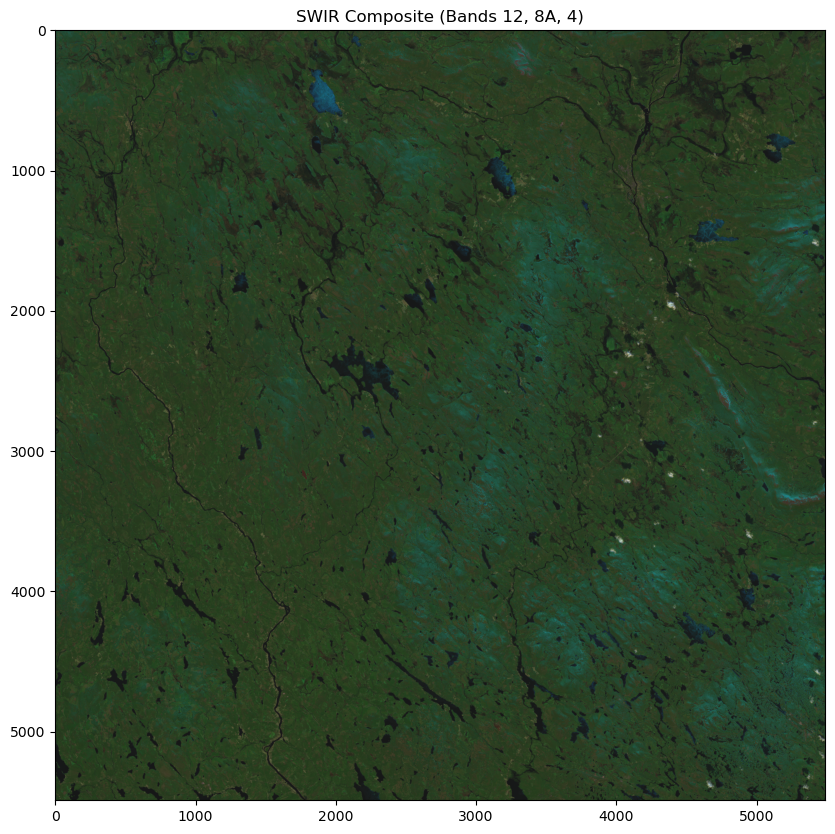

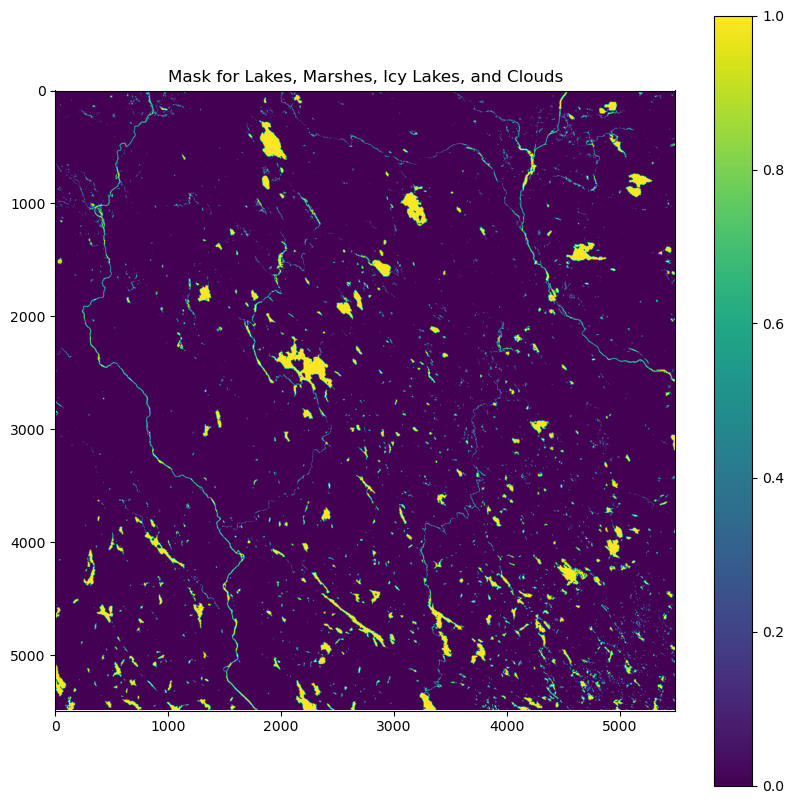

In [9]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.warp import reproject, Resampling

# Load Sentinel-2 bands and DEM data
def load_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform, src.crs, src

# Define paths for Sentinel-2 and DEM files
sentinel_path = "../data_store/data/S2B_MSIL2A_20230515T095559_N0509_R122_T35WMQ_20230515T113307.SAFE/GRANULE/L2A_T35WMQ_A032323_20230515T095746/IMG_DATA/R20m/"
dem_base_path = "../data_store/data/korkeusmalli/hila_2m/etrs-tm35fin-n2000/U4/"

# Load Sentinel-2 Bands: Band 12 (SWIR), Band 8A (NIR), Band 4 (Red) - now with .jp2 extension
band12_file = sentinel_path + "T35WMQ_20230515T095559_B12_20m.jp2"
band8a_file = sentinel_path + "T35WMQ_20230515T095559_B8A_20m.jp2"
band4_file = sentinel_path + "T35WMQ_20230515T095559_B04_20m.jp2"

band12, transform_band12, crs_band12, src_band12 = load_raster(band12_file)
band8a, transform_band8a, crs_band8a, src_band8a = load_raster(band8a_file)
band4, transform_band4, crs_band4, src_band4 = load_raster(band4_file)

# List all DEM files and dynamically assign the correct folder (U43 or U44)
dem_file_names = [
    "U4341G.tif", "U4341H.tif", "U4342G.tif", "U4342H.tif",
    "U4343A.tif", "U4343B.tif", "U4343C.tif", "U4343D.tif", "U4343E.tif", "U4343F.tif", "U4343G.tif", "U4343H.tif",
    "U4344A.tif", "U4344B.tif", "U4344C.tif", "U4344D.tif", "U4344E.tif", "U4344F.tif", "U4344G.tif", "U4344H.tif",
    "U4431G.tif", "U4433A.tif", "U4433C.tif", "U4433E.tif", "U4433G.tif"
]

# Function to assign correct folder based on file name prefix
def get_dem_path(filename):
    if filename.startswith("U43"):
        return dem_base_path + "U43/" + filename
    elif filename.startswith("U44"):
        return dem_base_path + "U44/" + filename
    else:
        raise ValueError(f"Unexpected DEM file name: {filename}")

# Generate full paths for each DEM file
dem_files = [get_dem_path(fname) for fname in dem_file_names]

# Load and merge DEM files
def merge_dems(dem_files):
    dem_list = []
    for file in dem_files:
        dem, transform_dem, crs_dem, src_dem = load_raster(file)
        dem_list.append(dem)
    merged_dem = np.maximum.reduce(dem_list)  # Simple maximum operation to merge DEMs
    return merged_dem, transform_dem, crs_dem

dem_combined, transform_dem_combined, crs_dem_combined = merge_dems(dem_files)

# Reproject DEM to match Sentinel-2 CRS and resolution (Band 12 for reference)
def reproject_raster(src_array, src_transform, src_crs, dst_transform, dst_crs, dst_shape, resampling=Resampling.nearest):
    dst_array = np.empty(dst_shape, dtype=src_array.dtype)
    reproject(
        source=src_array,
        destination=dst_array,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=resampling
    )
    return dst_array

# Reproject the DEM to match the Sentinel-2 data (SWIR band reference)
dem_reprojected = reproject_raster(
    dem_combined,
    transform_dem_combined,
    crs_dem_combined,
    transform_band12,
    crs_band12,
    band12.shape
)

# Create SWIR composite using bands 12, 8A, and 4 (for visualization)
def create_swir_composite(band12, band8a, band4):
    composite = np.dstack((band12, band8a, band4))
    return composite

swir_composite = create_swir_composite(band12, band8a, band4)

# Create a mask based on the SWIR composite (no gray_rock mask anymore)
def create_mask(swir_composite):
    # Thresholds based on the description of the features
    water_marsh_mask = (swir_composite[:, :, 0] < 1200)  # Dark in SWIR (water/marsh)
    #icy_lakes_mask = (swir_composite[:, :, 2] < 0.3) & (swir_composite[:, :, 1] < 0.4)  # Dark blue (ice on lakes)
    cloud_mask = (swir_composite[:, :, 0] > 5000) & (swir_composite[:, :, 1] > 5000) & (swir_composite[:, :, 2] > 5000)  # White clouds
    
    # Combine all masks
    combined_mask = np.logical_or.reduce([water_marsh_mask, cloud_mask])
    return combined_mask
    
mask = create_mask(swir_composite)

# Visualize the SWIR composite and the mask
def plot_image(image, title, cmap='gray'):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.show()

# Show SWIR composite (using bands 12, 8A, and 4)
def plot_swir_composite(swir_composite):
    plt.figure(figsize=(10, 10))
    plt.imshow(swir_composite / np.max(swir_composite))  # Normalize for visualization
    plt.title('SWIR Composite (Bands 12, 8A, 4)')
    plt.show()

# Show SWIR Composite
plot_swir_composite(swir_composite)

# Show the mask
plot_image(mask, 'Mask for Lakes, Marshes, Icy Lakes, and Clouds', cmap='viridis')


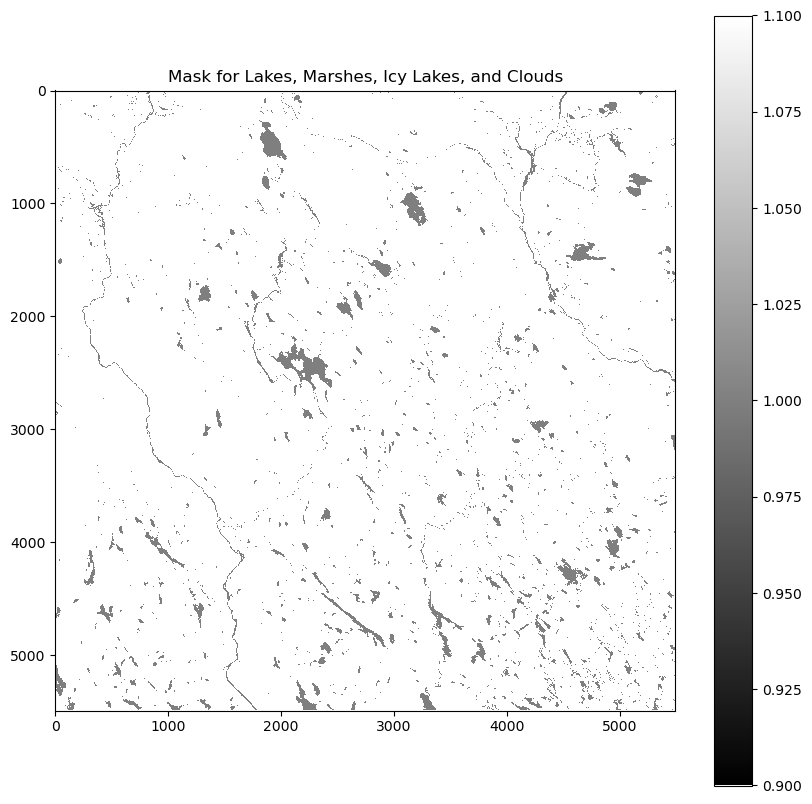

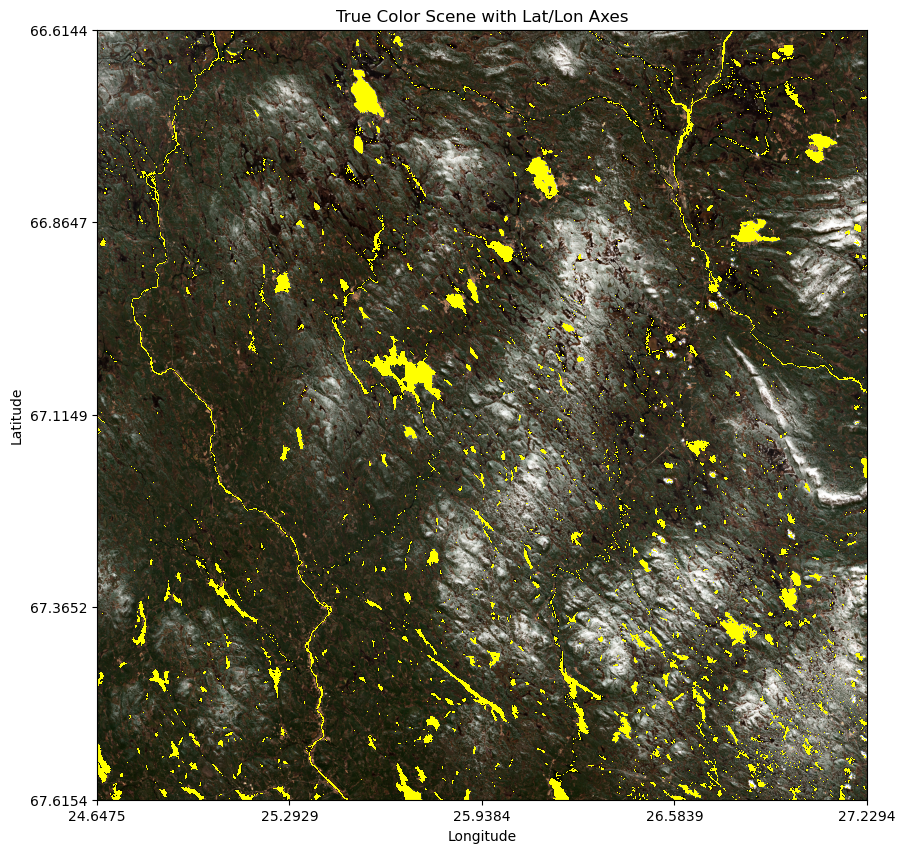

In [30]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.warp import reproject, Resampling
from pyproj import Transformer
from matplotlib.colors import ListedColormap

# Define paths for Sentinel-2 and DEM files
sentinel_path = "../data_store/data/S2B_MSIL2A_20230515T095559_N0509_R122_T35WMQ_20230515T113307.SAFE/GRANULE/L2A_T35WMQ_A032323_20230515T095746/IMG_DATA/R20m/"
dem_base_path = "../data_store/data/korkeusmalli/hila_2m/etrs-tm35fin-n2000/U4/"

# Define Sentinel-2 Band files
band12_file = sentinel_path + "T35WMQ_20230515T095559_B12_20m.jp2"  # SWIR
band8a_file = sentinel_path + "T35WMQ_20230515T095559_B8A_20m.jp2"  # NIR
band4_file = sentinel_path + "T35WMQ_20230515T095559_B04_20m.jp2"   # Red
band3_file = sentinel_path + "T35WMQ_20230515T095559_B03_20m.jp2"   # Green
band2_file = sentinel_path + "T35WMQ_20230515T095559_B02_20m.jp2"   # Blue

# Load Sentinel-2 bands and DEM data
def load_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform, src.crs, src

# Load the Sentinel-2 bands
band12, transform_band12, crs_band12, src_band12 = load_raster(band12_file)
band8a, transform_band8a, crs_band8a, src_band8a = load_raster(band8a_file)
band4, transform_band4, crs_band4, src_band4 = load_raster(band4_file)
band3, transform_band3, crs_band3, src_band3 = load_raster(band3_file)
band2, transform_band2, crs_band2, src_band2 = load_raster(band2_file)

# List of DEM file names without the folder prefix
dem_file_names = [
    "U4341G.tif", "U4341H.tif", "U4342G.tif", "U4342H.tif",
    "U4343A.tif", "U4343B.tif", "U4343C.tif", "U4343D.tif",
    "U4344A.tif", "U4344B.tif", "U4344C.tif", "U4344D.tif",
    "U4431G.tif", "U4433A.tif"
]

# Function to assign correct folder based on file name prefix
def get_dem_path(filename):
    if filename.startswith("U43"):
        return dem_base_path + "U43/" + filename
    elif filename.startswith("U44"):
        return dem_base_path + "U44/" + filename
    else:
        raise ValueError(f"Unexpected DEM file name: {filename}")

# Generate full paths for each DEM file
dem_files = [get_dem_path(fname) for fname in dem_file_names]

# Load and merge DEM files
def merge_dems(dem_files):
    dem_list = []
    for file in dem_files:
        dem, transform_dem, crs_dem, src_dem = load_raster(file)
        dem_list.append(dem)
    merged_dem = np.maximum.reduce(dem_list)  # Simple maximum operation to merge DEMs
    return merged_dem, transform_dem, crs_dem

# Merge all DEMs
dem_combined, transform_dem_combined, crs_dem_combined = merge_dems(dem_files)

# Reproject DEM to match Sentinel-2 CRS and resolution (Band 12 for reference)
def reproject_raster(src_array, src_transform, src_crs, dst_transform, dst_crs, dst_shape, resampling=Resampling.nearest):
    dst_array = np.empty(dst_shape, dtype=src_array.dtype)
    reproject(
        source=src_array,
        destination=dst_array,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=resampling
    )
    return dst_array

# Reproject the DEM to match the Sentinel-2 data (SWIR band reference)
dem_reprojected = reproject_raster(
    dem_combined,
    transform_dem_combined,
    crs_dem_combined,
    transform_band12,
    crs_band12,
    band12.shape
)

# Function to apply contrast stretching
def contrast_stretch(band, low_perc=2, high_perc=98):
    """
    Stretch the image contrast by clipping pixel values based on percentiles.
    """
    low = np.percentile(band, low_perc)
    high = np.percentile(band, high_perc)
    stretched_band = np.clip(band, low, high)
    stretched_band = (stretched_band - low) / (high - low) * 255  # Rescale to 0-255
    return stretched_band

# Create true color composite using bands 4, 3, and 2 with contrast adjustment
def create_true_color_composite(band4, band3, band2, apply_stretch=True):
    if apply_stretch:
        band4 = contrast_stretch(band4)
        band3 = contrast_stretch(band3)
        band2 = contrast_stretch(band2)

    # Stack the bands into a single composite image
    composite = np.dstack((band4, band3, band2))
    return composite.astype(np.uint8)  # Convert to 8-bit format

# Create SWIR composite using bands 12, 8A, and 4 (for visualization)
def create_swir_composite(band12, band8a, band4):
    composite = np.dstack((band12, band8a, band4))
    return composite

def create_mask(swir_composite):
    """
    Generates a mask where active areas are marked and inactive areas are set to NaN.
    """
    # Thresholds based on the description of the features
    water_marsh_mask = ((swir_composite[:, :, 0] < 1200))  # Dark in SWIR (water/marsh)
    cloud_mask = (swir_composite[:, :, 0] > 5000) & (swir_composite[:, :, 1] > 5000) & (swir_composite[:, :, 2] > 5000)  # White clouds
    
    # Combine all masks
    combined_mask = np.logical_or.reduce([water_marsh_mask, cloud_mask])
    #print(combined_mask)
    
    # Set mask to NaN where it's not active, and 1 where it is active
    combined_mask = np.where(combined_mask, 1, np.nan)
    
    return combined_mask

# Convert pixel coordinates to lat/lon (EPSG:4326)
def pixel_to_latlon(transform, crs, width, height):
    transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
    xs, ys = np.meshgrid(np.arange(width), np.arange(height))
    lon, lat = rasterio.transform.xy(transform, ys, xs, offset='center')
    lon = np.array(lon)
    lat = np.array(lat)
    lon_lat_transformed = np.vectorize(lambda x, y: transformer.transform(x, y))(lon, lat)
    return lon_lat_transformed[0], lon_lat_transformed[1]

# Visualize the SWIR composite and the mask
def plot_image(image, title, cmap='gray'):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap=cmap, interpolation='none')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Plot true color image with bright yellow mask overlay
def plot_true_color_with_mask(true_color_composite, mask=None, transform=None, crs=None, title="True Color Image"):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(true_color_composite)

    # Define a hard yellow colormap (banana yellow)
    banana_yellow = ListedColormap(['yellow'])

    # Overlay the mask in bright yellow, where the mask is active (mask != NaN)
    if mask is not None:
        ax.imshow(mask, cmap=banana_yellow, alpha=1, interpolation='none')  # Apply hard banana yellow with full alpha
    
    if transform is not None and crs is not None:
        lon, lat = pixel_to_latlon(transform, crs, true_color_composite.shape[1], true_color_composite.shape[0])
        ax.set_xticks(np.linspace(0, true_color_composite.shape[1], 5))
        ax.set_yticks(np.linspace(0, true_color_composite.shape[0], 5))
        ax.set_xticklabels(np.round(np.linspace(np.min(lon), np.max(lon), 5), 4))
        ax.set_yticklabels(np.round(np.linspace(np.min(lat), np.max(lat), 5), 4))
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
    
    ax.set_title(title)
    plt.show()

# Create SWIR composite and mask (if needed)
swir_composite = create_swir_composite(band12, band8a, band4)
mask = create_mask(swir_composite)  # Mask generation (can be omitted if not needed)

# # Show the mask
# plot_image(mask, 'Mask for Lakes, Marshes, Icy Lakes, and Clouds', cmap='gray')

# Create the true color composite with contrast adjustment
true_color_composite = create_true_color_composite(band4, band3, band2, apply_stretch=True)

# Plot true color scene with optional mask overlay
plot_true_color_with_mask(true_color_composite, mask=mask, transform=transform_band4, crs=crs_band4, title="True Color Scene with Lat/Lon Axes")
